In [1]:
import pandas as pd
import os
import glob
from rdflib import Graph
from urllib.request import urlopen
import subprocess
import time
from IPython.display import Markdown as md
from IPython.display import HTML
from pathlib import Path

# use ontobio!!
# pd.set_option('display.notebook_repr_html',False)
# https://github.com/jupyter/nbconvert/issues/946

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Mondo analysis

from ontobio.ontol_factory import OntologyFactory
mondo_file="/Users/matentzn/ws/mondo/src/ontology/mondo-qc.obo"
ofa = OntologyFactory()
ont = ofa.create(mondo_file)
ont.get_roots()[:3]

In [3]:
warnings = [Path(warn).stem for warn in glob.glob('../../sparql/*-warning.sparql')] 
NUMBER_ERRORS_SHOWN=15
PRIMARY_ONTOLOGY_FOR_QC="edit"

mondo="http://purl.obolibrary.org/obo/mondo.owl"
g = Graph()
g.parse("../mondo-qc.owl", format="xml")

In [4]:
def get_report(name):
    report_files= glob.glob('mondo-qc-*-%s.tsv' %(name))
    reports = []
    for f in report_files:
        try:
            df = pd.read_csv(f,sep="\t")
            df['ontology']=Path(f).stem.replace("-"+name,"").replace("mondo-qc-","")
            df.columns = [str(col).replace("?","") for col in df.columns]
            df.replace('[<]http[:][/][/]purl[.]obolibrary[.]org[/]obo[/]MONDO[_]','MONDO:', inplace=True,regex=True)
            df.replace('[>]$','', inplace=True, regex=True)
            reports.append(df)
        except pd.errors.EmptyDataError:
            print("WARNING! ", f, " is empty and has been skipped.")
    if reports:
        return pd.concat(reports)
    return pd.DataFrame(columns=['ontology'])

## Robot report analysis

In [5]:
dfx = get_report("robot-report-obo")

In [6]:
df = dfx.copy()
# Bug in ROBOT, wrong number of columns:
df.columns=['Rule Name', 'Subject', 'Property', 'Value','Trash','Ontology']
df['Level'] = df.index
df.reset_index(level=0, inplace=True)
del df['index']
del df['Trash']
df=df[df['Subject'].str.startswith('MONDO')]
props=df[['Rule Name','Value','Ontology']].groupby(['Ontology','Rule Name']).count().add_suffix('_count').reset_index()
props.sort_values(inplace=True, by=['Ontology','Value_count'], ascending=False)
props_pivot=props.pivot(index='Rule Name', columns='Ontology', values='Value_count') # Levellllll
cols = props_pivot.columns.tolist()
props_pivot[cols] = props_pivot[cols].fillna(0).astype(int)
props_pivot = pd.DataFrame(props_pivot.to_records())

## Overview of errors

This breaks down the errors in the generic ROBOT report. _Note that the whole report is filtered to only show results pertaining to MONDO classes themselves_. All tables are cut off at {{ NUMBER_ERRORS_SHOWN }} rows.

In [7]:
display(md("Table: Breakdown of the number of relationships in Mondo."))
display(HTML(props_pivot.to_html(index=False)))

Table: Breakdown of the number of relationships in Mondo.

Rule Name,2017,2018,2019,2020,current,edit,mondo-owl
annotation_whitespace,0,3,0,0,0,0,0
deprecated_class_reference,1,52,49,56,0,0,0
duplicate_definition,0,229,132,109,2,1,1
duplicate_exact_synonym,0,418,1662,1690,1688,1686,1686
duplicate_label,0,66,3,3,0,0,0
duplicate_scoped_synonym,2,3835,1443,1579,1597,1597,1597
equivalent_pair,0,28681,36995,37031,0,0,0
invalid_xref,0,1,4,0,0,0,0
lowercase_definition,1,332,391,387,300,147,147
missing_definition,0,0,0,0,0,0,0


In [8]:
display(md("## Detailed breakdown of errors: Editors file"))
dfo = df[df['Ontology']==PRIMARY_ONTOLOGY_FOR_QC]
for rule in dfo['Rule Name'].unique():
    display(md("#### %s" % rule.replace("_"," ").capitalize()))
    dfd = dfo[dfo['Rule Name']==rule].head(NUMBER_ERRORS_SHOWN)
    display(HTML(dfd.to_html(index=False)))

# Revealed a more complex issue we need to sort first: https://github.com/monarch-initiative/mondo/issues/1979
# https://github.com/ontodev/robot/issues/733 # Ignore 0021108 0045024 until ticket resolved.

## Detailed breakdown of errors: Editors file

#### Duplicate definition

Rule Name,Subject,Property,Value,Ontology,Level
duplicate_definition,MONDO:0001014,IAO:0000115,"A slowly progressing leukemia characterized by a clonal (malignant) proliferation of maturing and mature myeloid cells or mature lymphocytes. When the clonal cellular population is composed of myeloid cells, the process is called chronic myelogenous leukemia. When the clonal cellular population is composed of lymphocytes, it is classified as chronic lymphocytic leukemia, hairy cell leukemia, or T-cell large granular lymphocyte leukemia.",edit,ERROR


#### Multiple equivalent classes

Rule Name,Subject,Property,Value,Ontology,Level
multiple_equivalent_classes,MONDO:0021108,owl:equivalentClass,90b4dd24-4d0e-4f1c-9311-96810bb886e4genid331386,edit,ERROR
multiple_equivalent_classes,MONDO:0021108,owl:equivalentClass,90b4dd24-4d0e-4f1c-9311-96810bb886e4genid331390,edit,ERROR
multiple_equivalent_classes,MONDO:0045024,owl:equivalentClass,90b4dd24-4d0e-4f1c-9311-96810bb886e4genid358148,edit,ERROR
multiple_equivalent_classes,MONDO:0045024,owl:equivalentClass,90b4dd24-4d0e-4f1c-9311-96810bb886e4genid358152,edit,ERROR


#### Duplicate exact synonym

Rule Name,Subject,Property,Value,Ontology,Level
duplicate_exact_synonym,MONDO:0003401,oboInOwl:hasExactSynonym,yolk Sac tumor of the CNS,edit,WARN
duplicate_exact_synonym,MONDO:0016739,oboInOwl:hasExactSynonym,yolk Sac tumor of the CNS,edit,WARN
duplicate_exact_synonym,MONDO:0003404,oboInOwl:hasExactSynonym,yolk Sac tumor,edit,WARN
duplicate_exact_synonym,MONDO:0005744,oboInOwl:hasExactSynonym,yolk Sac tumor,edit,WARN
duplicate_exact_synonym,MONDO:0010420,oboInOwl:hasExactSynonym,XLP,edit,WARN
duplicate_exact_synonym,MONDO:0010627,oboInOwl:hasExactSynonym,XLP,edit,WARN
duplicate_exact_synonym,MONDO:0017304,oboInOwl:hasExactSynonym,XLOA,edit,WARN
duplicate_exact_synonym,MONDO:0021019,oboInOwl:hasExactSynonym,XLOA,edit,WARN
duplicate_exact_synonym,MONDO:0010209,oboInOwl:hasExactSynonym,xanthine oxidase deficiency,edit,WARN
duplicate_exact_synonym,MONDO:0018106,oboInOwl:hasExactSynonym,xanthine oxidase deficiency,edit,WARN


#### Missing definition

Rule Name,Subject,Property,Value,Ontology,Level
missing_definition,MONDO:0000005,IAO:0000115,NaN,edit,WARN
missing_definition,MONDO:0000009,IAO:0000115,NaN,edit,WARN
missing_definition,MONDO:0000014,IAO:0000115,NaN,edit,WARN
missing_definition,MONDO:0000023,IAO:0000115,NaN,edit,WARN
missing_definition,MONDO:0000030,IAO:0000115,NaN,edit,WARN
missing_definition,MONDO:0000032,IAO:0000115,NaN,edit,WARN
missing_definition,MONDO:0000045,IAO:0000115,NaN,edit,WARN
missing_definition,MONDO:0000049,IAO:0000115,NaN,edit,WARN
missing_definition,MONDO:0000050,IAO:0000115,NaN,edit,WARN
missing_definition,MONDO:0000060,IAO:0000115,NaN,edit,WARN


#### Duplicate scoped synonym

Rule Name,Subject,Property,Value,Ontology,Level
duplicate_scoped_synonym,MONDO:0000155,oboInOwl:hasExactSynonym,rare inborn error of sequestering of triglyceride,edit,WARN
duplicate_scoped_synonym,MONDO:0000155,oboInOwl:hasRelatedSynonym,rare inborn error of sequestering of triglyceride,edit,WARN
duplicate_scoped_synonym,MONDO:0000242,oboInOwl:hasExactSynonym,dermatophytosis of beard,edit,WARN
duplicate_scoped_synonym,MONDO:0000242,oboInOwl:hasRelatedSynonym,dermatophytosis of beard,edit,WARN
duplicate_scoped_synonym,MONDO:0000270,oboInOwl:hasExactSynonym,disorder of lower respiratory tract,edit,WARN
duplicate_scoped_synonym,MONDO:0000270,oboInOwl:hasRelatedSynonym,disorder of lower respiratory tract,edit,WARN
duplicate_scoped_synonym,MONDO:0000330,oboInOwl:hasExactSynonym,endemic typhus Fever,edit,WARN
duplicate_scoped_synonym,MONDO:0000330,oboInOwl:hasRelatedSynonym,endemic typhus Fever,edit,WARN
duplicate_scoped_synonym,MONDO:0000351,oboInOwl:hasExactSynonym,rare inborn error of methionine catabolic process,edit,WARN
duplicate_scoped_synonym,MONDO:0000351,oboInOwl:hasRelatedSynonym,rare inborn error of methionine catabolic process,edit,WARN


#### Lowercase definition

Rule Name,Subject,Property,Value,Ontology,Level
lowercase_definition,MONDO:0007477,IAO:0000115,"3M syndrome is a primordial growth disorder characterized by low birth weight, reduced birth length, severe postnatal growth restriction, a spectrum of minor anomalies (including facial dysmorphism) and normal intelligence.",edit,INFO
lowercase_definition,MONDO:0007989,IAO:0000115,"2 mm in diameter) from birth, peripheral iris hypopigmentation and transillumination defects leading to errors of refraction (myopia, astigmatism) and sometimes juvenile open angle glaucoma.",edit,INFO
lowercase_definition,MONDO:0008863,IAO:0000115,(2p21) genes.,edit,INFO
lowercase_definition,MONDO:0008872,IAO:0000115,"'Microcephalic osteodysplastic primordial dwarfism type II (MOPDII) is a form of microcephalic primordial dwarfism (MPD) characterized by severe pre- and postnatal growth retardation, with marked microcephaly in proportion to body size, skeletal dysplasia, abnormal dentition, insulin resistance, and increased risk for cerebrovascular disease.'",edit,INFO
lowercase_definition,MONDO:0008908,IAO:0000115,(14q21).,edit,INFO
lowercase_definition,MONDO:0009299,IAO:0000115,"46,XX gonadal dysgenesis (46,XX GD) is a primary ovarian defect leading to premature ovarian failure (POF) in otherwise normal 46,XX females as a result of failure of the gonads to develop or due to resistance to gonadotrophin stimulation.",edit,INFO
lowercase_definition,MONDO:0009371,IAO:0000115,"3 hydroxyisobutyric aciduria is characterised by ketoacidotic episodes, cerebral anomalies and facial dysmorphism. It is an organic aciduria that involves valine metabolism. Thirteen cases have been described in the literature so far. Transmission is thought to be autosomal recessive.",edit,INFO
lowercase_definition,MONDO:0009397,IAO:0000115,3.5 mM) from birth and associated with major hyperparathyroidism.,edit,INFO
lowercase_definition,MONDO:0009520,IAO:0000115,"3-hydroxy-3-methylglutaric aciduria (3HMG) is an organic aciduria, due to deficiency of 3-hydroxy-3-methylglutaryl-CoA-lyase (a key enzyme in ketogenesis and leucine metabolism) usually presenting in infancy with episodes of metabolic decompensation triggered by periods of fasting or infections, which when left untreated are life-threatening and may lead to neurological sequelae.",edit,INFO
lowercase_definition,MONDO:0009610,IAO:0000115,"3-methylglutaconic aciduria (3-MGA) type I is an inborn error of leucine metabolism with a variable clinical phenotype ranging from mildly delayed speech to psychomotor retardation, coma, failure to thrive, metabolic acidosis and dystonia.",edit,INFO


#### Missing superclass

Rule Name,Subject,Property,Value,Ontology,Level
missing_superclass,MONDO:0000065,rdfs:subClassOf,NaN,edit,INFO
missing_superclass,MONDO:0000070,rdfs:subClassOf,NaN,edit,INFO
missing_superclass,MONDO:0000162,rdfs:subClassOf,NaN,edit,INFO
missing_superclass,MONDO:0000224,rdfs:subClassOf,NaN,edit,INFO
missing_superclass,MONDO:0000252,rdfs:subClassOf,NaN,edit,INFO
missing_superclass,MONDO:0000261,rdfs:subClassOf,NaN,edit,INFO
missing_superclass,MONDO:0000263,rdfs:subClassOf,NaN,edit,INFO
missing_superclass,MONDO:0000266,rdfs:subClassOf,NaN,edit,INFO
missing_superclass,MONDO:0000405,rdfs:subClassOf,NaN,edit,INFO
missing_superclass,MONDO:0000421,rdfs:subClassOf,NaN,edit,INFO


## Other Quality Control checks

In [9]:
summary_data = []
all_tables = {}

for r in warnings:
    df_r = get_report(r)
    cols = df_r.columns.tolist()
    cols_term = df_r.columns.tolist()
    if 'term' in cols:
        cols.remove('term')
    if 'term_label' in cols:
        cols.remove('term_label')
        cols_term.remove('term_label')
    for o in df_r['ontology'].unique():
        df_ro=df_r[df_r['ontology']==o]
        summary_data.append([r,o,len(df_ro)])
    all_tables[r] = df_r

df_summary_data = pd.DataFrame(summary_data,columns=['check','ontology','errors'])
props_pivot=df_summary_data.pivot(index='check', columns='ontology', values='errors')
props_pivot = pd.DataFrame(props_pivot.to_records())
display(HTML(props_pivot.to_html(index=False)))

WARNING!  mondo-qc-2017-no-subclass-between-genetic-disease-warning.tsv  is empty and has been skipped.
WARNING!  mondo-qc-2018-no-subclass-between-genetic-disease-warning.tsv  is empty and has been skipped.
WARNING!  mondo-qc-edit-reflexive-warning.tsv  is empty and has been skipped.
WARNING!  mondo-qc-mondo-owl-reflexive-warning.tsv  is empty and has been skipped.
WARNING!  mondo-qc-2017-single-child-warning.tsv  is empty and has been skipped.


check,2017,2018,2019,2020,current,edit,mondo-owl
no-subclass-between-genetic-disease-warning,NaN,NaN,214.0,71.0,68.0,13.0,68.0
related-exact-synonym-warning,1.0,200.0,200.0,200.0,200.0,200.0,200.0
single-child-warning,NaN,1280.0,1637.0,1580.0,1559.0,1384.0,1559.0


In [10]:
for warning in all_tables:
    df_r = all_tables[warning] 
    df_ro=df_r[df_r['ontology']==PRIMARY_ONTOLOGY_FOR_QC]
    if (len(df_ro)>0):
        display(md("### Check: %s" % warning))
        display(md("#### %s (Errors: %d)" % (o,len(df_ro))))
        df_rd = df_ro.head(NUMBER_ERRORS_SHOWN).copy()
        display(HTML(df_rd.to_html(index=False)))

### Check: no-subclass-between-genetic-disease-warning

#### edit (Errors: 13)

term,term_label,d2,d2_label,ontology
MONDO:0009597,"metaphyseal chondrodysplasia, Spahr type",MONDO:0009943,Pyle disease,edit
MONDO:0044304,hyperphenylalaninemia due to DNAJC12 deficiency,MONDO:0009861,phenylketonuria,edit
MONDO:0012160,spondylometaphyseal dysplasia-cone-rod dystrophy syndrome,MONDO:0009943,Pyle disease,edit
MONDO:0009652,mucolipidosis type III gamma,MONDO:0018931,mucolipidosis type III,edit
MONDO:0008477,"spondylometaphyseal dysplasia, Kozlowski type",MONDO:0009943,Pyle disease,edit
MONDO:0009593,"spondylometaphyseal dysplasia, Sedaghatian type",MONDO:0009943,Pyle disease,edit
MONDO:0009711,congenital fiber-type disproportion myopathy,MONDO:0100084,actinopathy,edit
MONDO:0007982,"metaphyseal chondrodysplasia, Jansen type",MONDO:0009943,Pyle disease,edit
MONDO:0011211,axial spondylometaphyseal dysplasia,MONDO:0009943,Pyle disease,edit
MONDO:0010486,"palmoplantar keratoderma, mutilating, with periorificial keratotic plaques, X-linked",MONDO:0019014,mutilating palmoplantar keratoderma with periorificial keratotic plaques,edit


### Check: single-child-warning

#### edit (Errors: 1384)

term,total,ontology
MONDO:0021202,1,edit
MONDO:0007481,1,edit
MONDO:0002326,1,edit
MONDO:0021468,1,edit
MONDO:0003960,1,edit
MONDO:0011140,1,edit
MONDO:0021203,1,edit
MONDO:0021469,1,edit
MONDO:0002894,1,edit
MONDO:0006282,1,edit


### Check: related-exact-synonym-warning

#### edit (Errors: 200)

term,term_label,related,ontology
MONDO:0014756,"tremor, hereditary essential, 5",ETM5,edit
MONDO:0006999,tooth disease,disorder of calcareous tooth,edit
MONDO:0009424,Bartter disease type 2,hyperprostaglandin E syndrome 2,edit
MONDO:0017686,inborn aminoacylase deficiency,rare inborn error of aminoacylase activity,edit
MONDO:0020680,acute bronchiolitis,acute bronchiolitis,edit
MONDO:0000651,thoracic disease,disorder of thoracic segment of trunk,edit
MONDO:0003832,complement deficiency,disorder of complement activation,edit
MONDO:0002031,cecal disease,disorder of caecum,edit
MONDO:0011018,brachyolmia-amelogenesis imperfecta syndrome,DASS,edit
MONDO:0011012,African iron overload,iron overload in Africa,edit


## Mondo Statistics

In [11]:
df = get_report("term-stats")
df.drop_duplicates(inplace=True)

## Relationships

In [12]:
props=df[['term','property','ontology']].groupby(['ontology','property']).count().add_suffix('_count').reset_index()
props.sort_values(inplace=True, by=['ontology','term_count'], ascending=False)
props_pivot=props.pivot(index='property', columns='ontology', values='term_count')
props_pivot = pd.DataFrame(props_pivot.to_records())
cols = props_pivot.columns.tolist()
cols.remove('property')
props_pivot[cols] = props_pivot[cols].fillna(0).astype(int)
props_pivot.sort_values(by=['mondo-owl'],ascending=False,inplace=True)
props_pivot = props_pivot[['property','2017','2018','2019','2020','current','mondo-owl','edit']]
display(md("### Table: Breakdown of the number of relationships in Mondo."))
display(HTML(props_pivot.to_html(index=False)))

### Table: Breakdown of the number of relationships in Mondo.

property,2017,2018,2019,2020,current,mondo-owl,edit
<http://www.geneontology.org/formats/oboInOwl#hasDbXref,187,84157,99234,99326,99970,99979,128461
<http://www.w3.org/2004/02/skos/core#exactMatch,0,0,69877,69979,70554,70557,0
<http://www.geneontology.org/formats/oboInOwl#hasExactSynonym,22,42059,63390,63636,64406,64437,64437
<http://www.w3.org/2000/01/rdf-schema#subClassOf,106,35535,46835,46891,47533,47560,46987
<http://www.geneontology.org/formats/oboInOwl#hasRelatedSynonym,2,24730,37814,37757,37873,37867,37867
<http://www.w3.org/1999/02/22-rdf-syntax-ns#type,879,20750,23555,23623,24236,24243,24243
<http://www.geneontology.org/formats/oboInOwl#id,0,20750,23443,23510,24119,24126,24126
<http://www.w3.org/2000/01/rdf-schema#label,879,20750,23442,23510,24119,24126,24126
<http://www.w3.org/2004/02/skos/core#closeMatch,0,0,16375,16273,16510,16512,0
<http://purl.obolibrary.org/obo/IAO_0000115,6,11711,15425,15452,15500,15505,15505


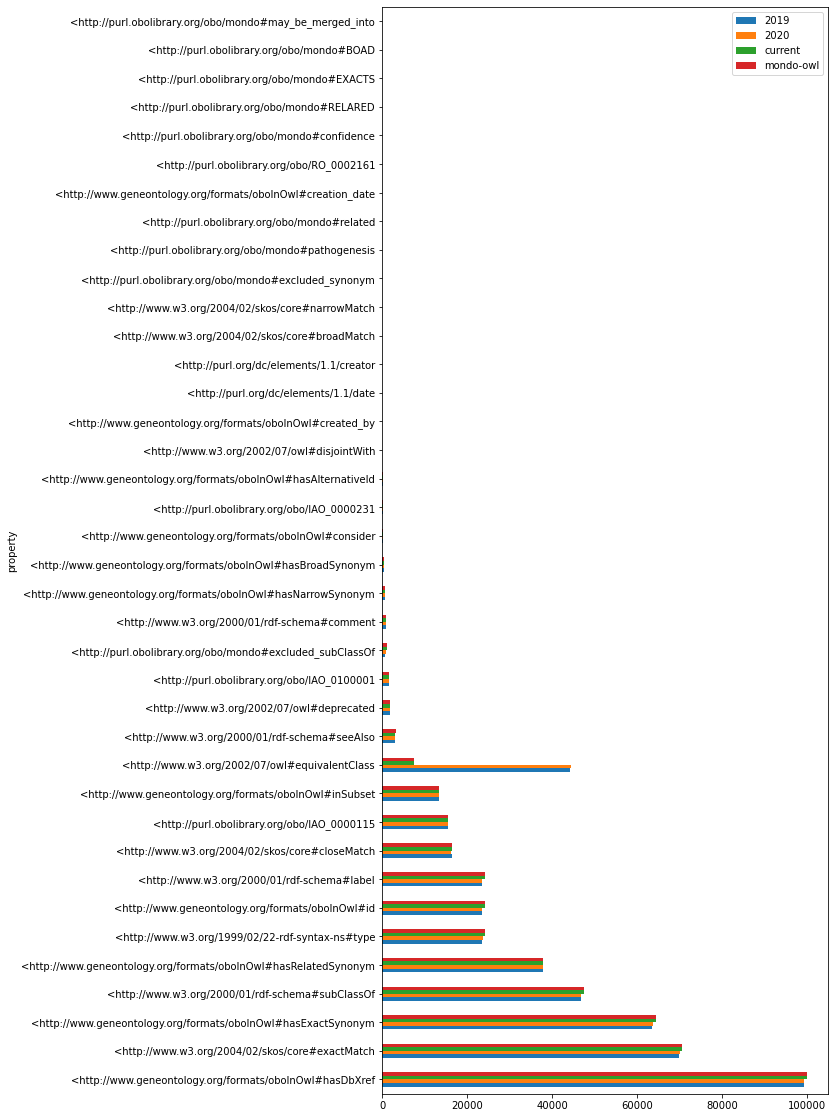

In [13]:
m = pd.melt(props_pivot.head(10), id_vars=["property"])
m = props_pivot[['property','2019','2020','current','mondo-owl']]
m.set_index('property').plot.barh(figsize=(8,20))

In [14]:
current_to_release_diff=props_pivot[['property', 'mondo-owl', 'current']]
current_to_release_diff=current_to_release_diff[current_to_release_diff['current']!=current_to_release_diff['mondo-owl']]
current_to_release_diff.dropna(inplace=True)
current_to_release_diff['difference']=current_to_release_diff['mondo-owl']-current_to_release_diff['current']
current_to_release_diff.sort_values(by=['difference'],ascending=False,inplace=True)
current_to_release_diff[['mondo-owl', 'current','difference']] = current_to_release_diff[['mondo-owl', 'current','difference']].astype(int)
display(md("### Table: Current release vs Edit release: Differences in the number of specific relations"))
display(HTML(current_to_release_diff.to_html(index=False)))

### Table: Current release vs Edit release: Differences in the number of specific relations

property,mondo-owl,current,difference
<http://www.geneontology.org/formats/oboInOwl#hasExactSynonym,64437,64406,31
<http://www.w3.org/2000/01/rdf-schema#subClassOf,47560,47533,27
<http://www.geneontology.org/formats/oboInOwl#hasDbXref,99979,99970,9
<http://www.w3.org/2000/01/rdf-schema#seeAlso,3159,3150,9
<http://www.w3.org/2002/07/owl#equivalentClass,7414,7406,8
<http://www.w3.org/2000/01/rdf-schema#comment,968,961,7
<http://www.w3.org/1999/02/22-rdf-syntax-ns#type,24243,24236,7
<http://www.geneontology.org/formats/oboInOwl#id,24126,24119,7
<http://www.w3.org/2000/01/rdf-schema#label,24126,24119,7
<http://www.geneontology.org/formats/oboInOwl#created_by,75,70,5


How many x have changes since the last release: 

- Source overlap (how many terms from each source are covered?)
- Measure changes between subclasses based on OMIM vs MOndo (etc)
